##  Problem Statement

In this programming assignment, your task is to classify geographical locations according to their predicted tree cover using Gradient Boosting and Random Forest classifiers. You are expected to fill in functions that would complete this task. All of the necessary helper code is included in this notebook. However, we advise you to go over the slides, lecture material, the EdX videos and the corresponding notebooks before you attempt this Programming Assignment. You can find information about the dataset to be used in the following links:

* **Dataset:** http://archive.ics.uci.edu/ml/datasets/Covertype 

* **Dataset description:** http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info

##  Notebook Setup

In [1]:
# To time the entire solution
import time
start_nb = time.time()

In [2]:
from pyspark import SparkContext
sc=SparkContext()

In [3]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

import os
import pickle
from os.path import exists

%config IPCompleter.greedy=True

In [4]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
print('Tree Cover Types:', CoverTypes)

Tree Cover Types: {1.0: 'Spruce/Fir', 2.0: 'Lodgepole Pine', 3.0: 'Ponderosa Pine', 4.0: 'Cottonwood/Willow', 5.0: 'Aspen', 6.0: 'Douglas-fir', 7.0: 'Krummholz'}


## Collecting Data

In [5]:
def get_data(file_path):
    %cd $file_path
    if not exists('covtype'):
        print("creating directory covtype")
        !mkdir covtype
    %cd covtype
    if not exists('covtype.data'):
        if not exists('covtype.data.gz'):
            print('downloading covtype.data.gz')
            !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
        print('decompressing covtype.data.gz')
        !gunzip -f covtype.data.gz
    !ls -l
    %cd ../

In [6]:
file_path = os.getcwd()
get_data(file_path) 

/home/ucsddse230/work/BigDataWithSpark/Week4/pa6
/home/ucsddse230/work/BigDataWithSpark/Week4/pa6/covtype
total 73408
-rwxrwxrwx 1 ucsddse230 staff 75169317 Jul 31 18:51 covtype.data
/home/ucsddse230/work/BigDataWithSpark/Week4/pa6


In [7]:
# Break up features that are made out of several binary features.
def get_columns(cols_txt):
    cols=[a.strip() for a in cols_txt.split(',')]
    colDict={a:[a] for a in cols}
    colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
    colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
    columns=[]
    for item in cols:
        columns = columns + colDict[item]
    return columns
    #print(columns)

In [8]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""
columns = get_columns(cols_txt)

In [9]:
print(columns)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [10]:
# Read the file into an RDD
# When using sc.textRead you need to use an absolute path.
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path=file_path + '/covtype/covtype.data'
inputRDD=sc.textFile(path)

inputRDD.take(3)

['2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5',
 '2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5',
 '2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2']

## Helper Functions
Here are some helper functions that you will have to fill up.

### label_RDD

The function <font color="blue">label_RDD</font> takes an RDD as input and returns an RDD of labeled points

Input: RDD consisting of a string with comma separated values (InputRDD)


**<font color="magenta" size=2>Example Input</font>**
``` python
'2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5'
```
Output: RDD of the type LabeledPoint with the first element being the label and second element being a DenseVector that contains all the elements of the InputRDD(Except the last value which is the label).

**<font color="blue" size=2>Example Output</font>**
``` python
LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
```



In [11]:
## Insert your answer in this cell. DO NOT CHANGE THE NAME OF THE FUNCTION.
import numpy as np

def processCoverEntry(entry):
    if (not entry):
        raise Exception("Invalid argument when processing cover entries.")
    
    # Splitting string line.
    fields = [field.strip() for field in entry.split(",")]
    
    numFields = len(fields)
    
    if (numFields < 1):
        raise Exception("Invalid argument when processing cover entries.")
    
    # According to the documentation we should use Numpy array as
    # the dense vector for Python. However, I use a dense Vector
    # to be consistent with the assignment notebook.
    if (numFields == 1):
        return LabeledPoint(fields[0], Vectors.dense([]))
    
    # Negative label to get the last label on first argument.
    # On the second I get all elements from the list excluding the last one (0: - 1).
    return LabeledPoint(fields[-1], Vectors.dense(fields[0 : -1]))
    

def label_RDD(inputRDD):
    #
    # YOUR CODE HERE
    #
    Data = inputRDD.map(processCoverEntry)
    
    return Data

In [12]:
Data = label_RDD(inputRDD)
Data.cache()
Data.take(3)

[LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(5.0, [2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(2.0, [2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])]

In [13]:
assert Data.first().label == 5.0
assert Data.first().features == Vectors.dense([2596.0, 51.0, 3.0, 258.0, 0.0, 510.0, 221.0, 232.0, 148.0, 6279.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### count_examples

The function <font color="blue">count_examples</font> takes an RDD as input and returns count of number of labels belonging to each class

Input: RDD obtained as the output of the labelRDD


**<font color="magenta" size=2>Example Input</font>**
``` python
[LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(5.0, [2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(2.0, [2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])]
```
Output: list of tuples (label, count)

**NOTE: The outputs need to be sorted in descending order by counts**

**<font color="blue" size=2>Example Output</font>**
``` python
[(5.0, 2), (2.0, 1)]
```

In [14]:
## Insert your answer in this cell. DO NOT CHANGE THE NAME OF THE FUNCTION.
def count_examples(Data):
    labelCount = Data.map(lambda x: (x.label, 1)).\
                    reduceByKey(lambda x,y: x+y)
    return labelCount.collect()

In [15]:
counts = count_examples(Data)

In [16]:
counts3 = count_examples(sc.parallelize(Data.take(3)))

In [17]:
assert type(counts3) == list, 'Incorrect return type'
assert type(counts3[0]) == tuple, 'Incorrect return type'
assert type(counts3[0][0]) == float, 'Incorrect return type'
assert type(counts3[0][1]) == int, 'Incorrect return type'

In [18]:
assert counts3[0][0] == 5.0, 'Incorrect return value'
assert counts3[0][1] == 2, 'Incorrect return value'

In [19]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [20]:
total=Data.count()
print('total data size=',total)
print('              type (label):   percent of total')
print('---------------------------------------------------------')
print('\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a[0]],a[0],100.0*a[1]/float(total)) for a in counts]))

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Ponderosa Pine (3.0):	6.15
         Douglas-fir (6.0):	2.99
          Spruce/Fir (1.0):	36.46
           Krummholz (7.0):	3.53
   Cottonwood/Willow (4.0):	0.47
               Aspen (5.0):	1.63
      Lodgepole Pine (2.0):	48.76


### labels_to_binary (Making the problem binary)

The implementation of BoostedGradientTrees in MLLib supports only binary problems. the `CovType` problem has
7 classes. To make the problem binary we choose the `Lodgepole Pine` (label = 2.0). We therefore transform the dataset to a new dataset where the label is `1.0` is the class is `Lodgepole Pine` and is `0.0` otherwise.

The function <font color="blue">labels_to_binary</font> takes an RDD as input and returns an RDD with binary labels
such that: 

```python
if label == 2:      #Since label 2 has the highest count value
    new_label = 1
    
else:
    new_label = 0
```

Input: Labelled RDD (Output from <font color="blue">label_RDD</font> function)


**<font color="magenta" size=2>Example Input</font>**
``` python
LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
```
Output: The same RDD with label of all entries as 0 except for label = 2.0 where label becomes 1.0

**<font color="blue" size=2>Example Output</font>**
``` python
LabeledPoint(0.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
```

In [21]:
## Insert your answer in this cell. DO NOT CHANGE THE NAME OF THE FUNCTION.
def pair_label_to_binary(pair):
    new_label = 0 
    if pair.label == 2:      #Since label 2 has the highest count value
        new_label = 1
        
    pair.label = new_label
    return pair

def labels_to_binary(Data):
    #
    # YOUR CODE HERE
    #
    
    return Data.map(pair_label_to_binary)

In [22]:
Data = labels_to_binary(Data)

In [23]:
assert Data.first().label == 0.0
Data.take(3)

[LabeledPoint(0.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(0.0, [2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(1.0, [2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])]

### Reducing data size
For this assignment, we will use only 10% of the original data.

In [24]:
trainingData = sc.parallelize(pickle.load(open('training10p.pkl', 'rb')))
testData = sc.parallelize(pickle.load(open('test10p.pkl', 'rb')))

In [25]:
print('Sizes: Data1=%d, trainingData=%d, testData=%d'%(trainingData.cache().count() + testData.cache().count(),trainingData.cache().count(),testData.cache().count()))

Sizes: Data1=58100, trainingData=40682, testData=17418


In [26]:
counts = count_examples(testData)

## Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees)

### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

### Example

The function <font color="blue">Classify_GB</font> takes as inputs:

1. **trainingData**: Training data (Type: RDD)
2. **testData**: Test data (Type: RDD)
3. **maxDepth**: Depth of tree (Type: int)

The function trains a GradientBoostedTrees classifier and returns the error

**Output**: error (Type: float)

**<font color="blue" size=2>Example Output</font>**
``` python
error=0.3
```

### Definition

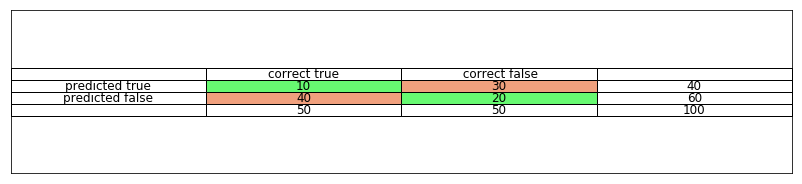

Precision: 0.25
Recall: 0.2
Accuracy: 0.3
F1-Score: 0.2222222222222222


In [27]:
# Adding this function for fun, it is outside of the assingment.
%matplotlib inline
import matplotlib.pyplot as plt

# In predictive analytics, a table of confusion (sometimes also called a confusion matrix),
# is a table with two rows and two columns that reports the number of false positives, 
# false negatives, true positives, and true negatives. 
# This allows more detailed analysis than mere proportion of correct classifications (accuracy).
# Accuracy is not a reliable metric for the real performance of a classifier,
# because it will yield misleading results if the data set is unbalanced
# (that is, when the numbers of observations in different classes vary greatly).
def render_Confusion_Matrix(tp, tn, fp, fn, dataCount):
    goodColor = "#67f971"
    badColor = "#f0a07d"
    table = [
        ["", "correct true", " correct false", ""],
        ["predicted true", tp, fp, tp + fp],
        ["predicted false", fn, tn, fn + tn],
        ["", tp + fn, fp + tn, dataCount]
    ]
    
    # Table plot.
    plt.figure(1, figsize=(14, 3))
    table = plt.table(cellText=table, loc=(0,0), cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table._cells[(1, 1)].set_facecolor(goodColor)
    table._cells[(2, 2)].set_facecolor(goodColor)
    table._cells[(1, 2)].set_facecolor(badColor)
    table._cells[(2, 1)].set_facecolor(badColor)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
    # Plotting some derivations from the confusion matrix.
    if (dataCount != tp + fp + tn + fn):
        print ("Counting Mismatch, the number of predictions doesn't match with the test data size.")
    
    # In the field of information retrieval, precision is the fraction
    # of retrieved documents that are relevant to the query.
    precision = tp / (tp + fp)
    
    # In information retrieval,
    # recall is the fraction of the relevant documents that are successfully retrieved. 
    recall = tp / (tp + fn)
    
    # The F1 score is the harmonic average of the precision and recall,
    # where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. 
    f1 = 2 / ((1/precision) +  (1/recall))
    
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("Accuracy: {0}".format((tp+tn)/dataCount))
    print("F1-Score: {0}".format(f1))


def print_Confusion_Matrix(labelsAndPredictions, dataCount):
    labelIndex = 0
    predictionIndex = 1  
    labelCount = labelsAndPredictions.map(lambda lp: (lp[labelIndex], 1)).\
        reduceByKey(lambda x,y: x + y)
    
    correctPreditions = labelsAndPredictions.\
        filter(lambda lp: lp[labelIndex] == lp[predictionIndex]).cache()
        
    truePositives = correctPreditions.filter(lambda lp: lp[labelIndex] > 0.0).count()
    trueNegatives = correctPreditions.filter(lambda lp: lp[labelIndex] < 1.0).count()
        
    wrongPreditions = labelsAndPredictions.\
        filter(lambda lp: lp[labelIndex] != lp[predictionIndex]).cache()
        
    falsePositives = wrongPreditions.filter(lambda lp: lp[labelIndex] > 0.0).count()
    falseNegatives = wrongPreditions.filter(lambda lp: lp[labelIndex] < 1.0).count()
    
    render_Confusion_Matrix(
        truePositives,
        trueNegatives,
        falsePositives,
        falseNegatives,
        dataCount)

# Confusion matrix example, check how the numbers are related
# between columns and rows and the calculated measures which
# appears from sums of the first row, column and diagonal.
# Those values are summarized on the F1 score, which is bad on this
# example (the best score is 1 and zero is the worst).
render_Confusion_Matrix(10, 20, 30, 40, 100)
        

In [28]:
## Insert your answer in this cell. DO NOT CHANGE THE NAME OF THE FUNCTION.
def Classify_GB(trainingData, testData, maxDepth):
    #
    # YOUR CODE HERE
    #
    
    
    # Empty categoricalFeaturesInfo indicates all features are continuous.
    model = GradientBoostedTrees.trainClassifier(
        trainingData,
        categoricalFeaturesInfo={},
        maxDepth = maxDepth)

    # Mapping all test results with expected labels and counting the percentage of errors.
    testDataCount = testData.count()
    predictions = model.predict(testData.map(lambda lp : lp.features))
    labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)    
    testErr = labelsAndPredictions.filter(
        lambda lp: lp[0] != lp[1]).count() / float(testDataCount)
    
    print_Confusion_Matrix(labelsAndPredictions, testDataCount)    
    return testErr


### Test cases

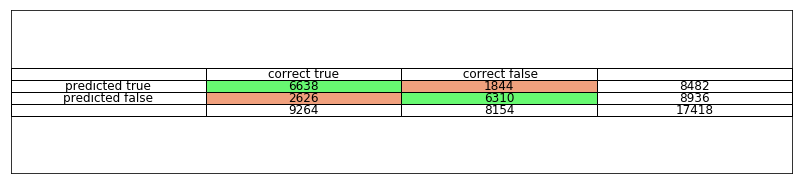

Precision: 0.7825984437632634
Recall: 0.7165371329879102
Accuracy: 0.743368928694454
F1-Score: 0.7481122506480333


In [29]:
visible_results=pickle.load(open('GradientBoostingResultsVisible.pkl','rb'))
assert Classify_GB(trainingData, testData, 1) <= visible_results['B_10p_1'] 

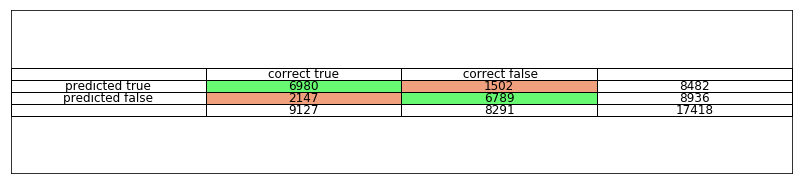

Precision: 0.8229191228483849
Recall: 0.7647638873671524
Accuracy: 0.790504076242967
F1-Score: 0.7927764211482764


In [30]:
# From Spark Mlib documentation:
# Deeper trees are more expressive
# (potentially allowing higher accuracy), but they are also 
# more costly to train and are more likely to overfit.
assert Classify_GB(trainingData, testData, 3) <= visible_results['B_10p_3']

In [31]:
#Hidden Tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [32]:
#Hidden Tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


## Random Forests

### Introduction

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees.RandomForest documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest)

**trainClassifier**`(data, numClasses, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=None)`   
Method to train a decision tree model for binary or multiclass classification.

**Parameters:**  
* *data* – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1, ..., numClasses-1}.  
* *numClasses* – number of classes for classification.  
* *categoricalFeaturesInfo* – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.  
* *numTrees* – Number of trees in the random forest.  
* *featureSubsetStrategy* – Number of features to consider for splits at each node. Supported: “auto” (default), “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “sqrt”.
* *impurity* – Criterion used for information gain calculation. Supported values: “gini” (recommended) or “entropy”.  
* *maxDepth* – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 4)  
* *maxBins* – maximum number of bins used for splitting features (default: 32)
* *seed* – Random seed for bootstrapping and choosing feature subsets.  

**Returns:**	
RandomForestModel that can be used for prediction

### Example
The function <font color="blue">Classify_RF</font> takes as inputs:

1. **trainingData**: Training data (Type: RDD)
2. **testData**: Test data (Type: RDD)
3. **maxDepth**: Depth of tree (Type: int)

The function trains a RandomForest classifier and returns the error in classification

**Output**: error (Type: float)

**<font color="blue" size=2>Example Output</font>**
``` python
error=0.3
```

Note: You are allowed to alter the number of trees parameter

### Definition

In [33]:
## Insert your answer in this cell. DO NOT CHANGE THE NAME OF THE FUNCTION.
def Classify_RF(trainingData, testData, depth):    
    #
    # YOUR CODE HERE
    #
    
    optNumTrees = 1
    maxNumTrees = 32
    optErr = 1.0
    optResult = None
    testDataCount = testData.count()
    
    # Since this algorithm is faster than boosting tree,
    # we will iterate through multiple tree sizes to find the
    # value with biggest accuracy.
    for numTrees in range(1, maxNumTrees + 1):
        # Empty categoricalFeaturesInfo indicates all features are continuous.
        # Gini impurity is a measure of how often a randomly chosen element 
        # from the set would be incorrectly labeled if it was randomly labeled
        # according to the distribution of labels in the subset. This parameter is used
        # to choose how to split a parameter in a tree node.
        model = RandomForest.trainClassifier(
            trainingData,
            categoricalFeaturesInfo={},
            featureSubsetStrategy='auto',
            impurity='gini',
            maxDepth=depth,
            numClasses=2,
            numTrees=numTrees,
            maxBins=32,
            seed=None)

        # Mapping all test results with expected labels and counting the percentage of errors.
        predictions = model.predict(testData.map(lambda lp : lp.features))
        labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)    
        testErr = labelsAndPredictions.filter(
            lambda lp: lp[0] != lp[1]).count() / float(testDataCount)
        
        if (testErr < optErr):
            optNumTrees = numTrees
            optErr = testErr
            optResult = labelsAndPredictions

    trees = "trees"
    if (optNumTrees == 1):
        trees = "tree"
        
    print("Best result found for RF using {0} {1}:".format(optNumTrees, trees))
    print_Confusion_Matrix(labelsAndPredictions, testDataCount)    
    return optErr


### Test cases

Best result found for RF using 25 trees:


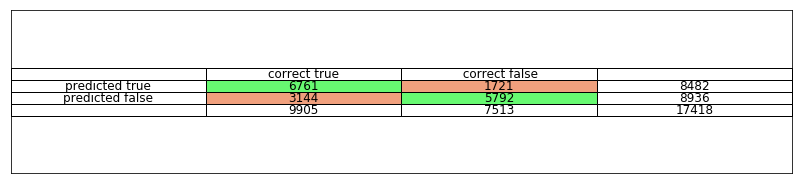

Precision: 0.7970997406272106
Recall: 0.6825845532559314
Accuracy: 0.7206912389482145
F1-Score: 0.7354108881274815


In [34]:
visible_results_rf=pickle.load(open('RandomForestResultsVisible.pkl','rb'))
assert Classify_RF(trainingData, testData, 3) <= visible_results_rf['RF_10p_3'] 

Best result found for RF using 1 tree:


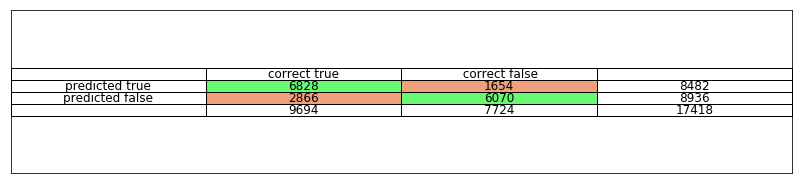

Precision: 0.8049988210327753
Recall: 0.704353208170002
Accuracy: 0.7404983350556895
F1-Score: 0.7513204225352113


In [35]:
assert Classify_RF(trainingData, testData, 6) <= visible_results_rf['RF_10p_6']

In [36]:
#Hidden Tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [37]:
#Hidden Tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [38]:
end_nb = time.time()
print("Total time taken: ", end_nb - start_nb)

Total time taken:  650.3856103420258
